In [1]:
import Pyomic
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
data=pd.read_csv('/Users/fernandozeng/Desktop/mouse_skin/raw_data/counts.txt',index_col=0,sep='\t',header=1)
data.columns=[i.split('/')[-1].replace('.bam','') for i in data.columns]
data.head()

,1--1,1--2,2--1,2--2,3--1,3--2,4--1,4--2,4-3,4-4,Blank-1,Blank-2
Geneid,,,,,,,,,,,,
ENSMUSG00000102628,0,0,0,0,5,0,0,0,0,0,0,9
ENSMUSG00000100595,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000097426,5,0,0,0,0,0,0,1,0,0,0,0
ENSMUSG00000104478,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104385,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
pair=pd.read_csv('data/pair/pair_GRCm39.tsv',sep='\t',index_col=0)
pair.head()

,symbol
gene_id,
ENSMUSG00000102628,Gm37671
ENSMUSG00000100595,Gm19087
ENSMUSG00000097426,Gm8941
ENSMUSG00000104478,Gm38212
ENSMUSG00000104385,Gm7449


In [4]:
ret_gene=list(set(data.index.tolist()) & set(pair.index.tolist()))
len(ret_gene)

55405

In [5]:
data=data.loc[ret_gene]
new_index=[]
for i in ret_gene:
    a=pair.loc[i,'symbol']
    if str(a)=='nan':
        new_index.append(i)
    else:
        new_index.append(a)
data.index=new_index

In [6]:
dds=Pyomic.bulk.pyDEseq(data)
dds.drop_duplicates_index()
dds.normalize()
result=dds.deg_analysis(['4-3','4-4'],['1--1','1--2'],method='ttest')
result.head()

,pvalue,qvalue,FoldChange,-log(pvalue),-log(qvalue),BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,sig
Gm48476,NaN,0.000000,1.000000,NaN,inf,0.000000,-inf,0.000000,0.000000,0.100000,sig
Mok,0.655472,0.726578,1.133217,0.183446,0.138718,64.616749,5.013836,0.180424,0.180424,0.113322,normal
Ube2v2,0.487798,0.578191,0.788299,0.311760,0.237929,693.026925,8.436768,-0.343185,0.343185,0.078830,normal
Gm11633,0.863380,0.897319,0.847341,0.063798,0.047053,4.410946,1.141088,-0.238985,0.238985,0.084734,normal
Gemin2,0.990151,0.992810,0.997531,0.004299,0.003134,333.993574,7.383677,-0.003566,0.003566,0.099753,normal


In [7]:
dds=Pyomic.bulk.pyDEseq(data)
dds.drop_duplicates_index()
dds.normalize()
result=dds.deg_analysis(['4-3','4-4'],['1--1','1--2'],method='ttest')
result.head()

,pvalue,qvalue,FoldChange,-log(pvalue),-log(qvalue),BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,sig
Gm48476,NaN,0.000000,1.000000,NaN,inf,0.000000,-inf,0.000000,0.000000,0.100000,sig
Mok,0.655472,0.726578,1.133217,0.183446,0.138718,64.616749,5.013836,0.180424,0.180424,0.113322,normal
Ube2v2,0.487798,0.578191,0.788299,0.311760,0.237929,693.026925,8.436768,-0.343185,0.343185,0.078830,normal
Gm11633,0.863380,0.897319,0.847341,0.063798,0.047053,4.410946,1.141088,-0.238985,0.238985,0.084734,normal
Gemin2,0.990151,0.992810,0.997531,0.004299,0.003134,333.993574,7.383677,-0.003566,0.003566,0.099753,normal


In [8]:
print(result.shape)
result=result.loc[result['log2(BaseMean)']>1]
print(result.shape)

(54504, 11)
(21277, 11)


... Fold change threshold: 1.57007275110713


<AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

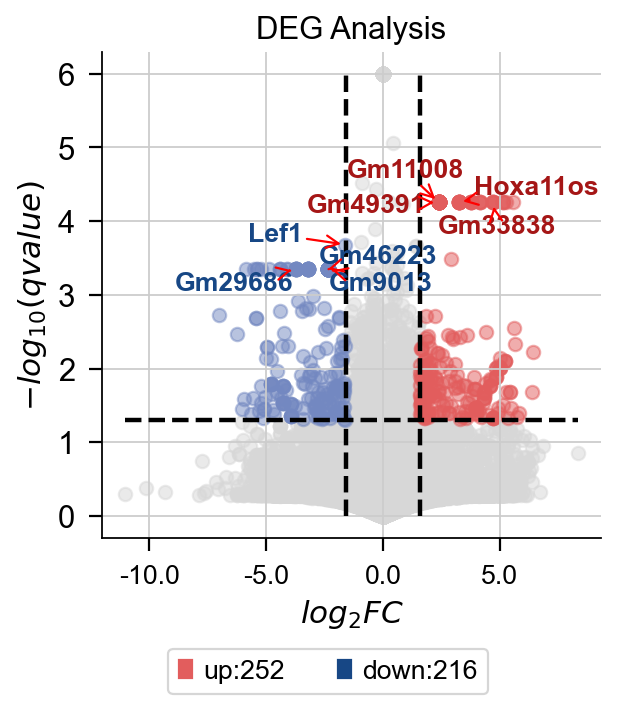

In [9]:
dds.foldchange_set()
dds.plot_volcano(title='DEG Analysis',plot_genes_num=8,plot_genes_fontsize=12,)

In [10]:
import pandas as pd
go_bio_geneset=pd.read_csv('data/geneset/WikiPathways_2019_Mouse.txt',sep='\t\t',header=None)
go_bio_dict={}
for i in go_bio_geneset.index:
    go_bio_dict[go_bio_geneset.loc[i,0]]=[i.lower().capitalize() for i in go_bio_geneset.loc[i,1].split('\t')]

In [11]:
enr=Pyomic.bulk.geneset_enrichment(gene_list=dds.result.loc[dds.result['sig']!='normal'].index.tolist(),
                                  pathways_dict=go_bio_dict,pvalue_type='auto',
                                  organism='mouse')

<AxesSubplot: title={'center': 'Wiki Pathway enrichment'}, xlabel='Fractions of genes'>

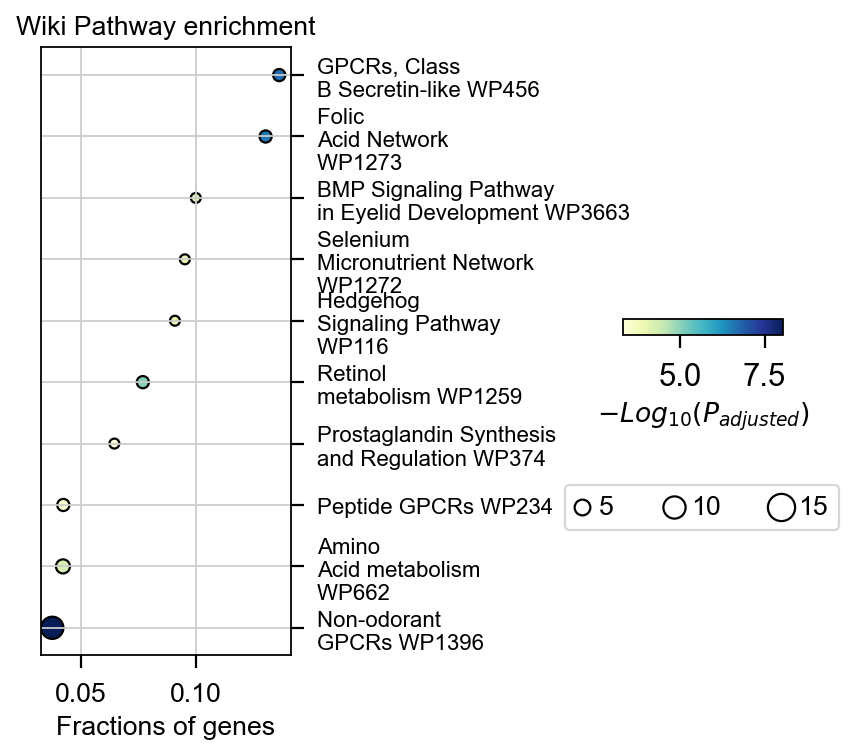

In [13]:
Pyomic.bulk.geneset_plot(enr,figsize=(2,5),fig_title='Wiki Pathway enrichment')